In [2]:
import tensorflow as tf
from numpy.random import seed
seed(101)

tf.random.set_seed(101)

import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir('F:/')
os.getcwd()

'F:\\'

In [4]:
df_data = pd.read_csv('../input/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [6]:

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [7]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [8]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [9]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [10]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [11]:
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [12]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [13]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [14]:
df_data.set_index('image_id', inplace=True)

In [15]:
base_dir = '../input/base_dir'

train_dir = os.path.join(base_dir, 'train_dir')


val_dir = os.path.join(base_dir, 'val_dir')




# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')

mel = os.path.join(train_dir, 'mel')

bkl = os.path.join(train_dir, 'bkl')

bcc = os.path.join(train_dir, 'bcc')

akiec = os.path.join(train_dir, 'akiec')

vasc = os.path.join(train_dir, 'vasc')

df = os.path.join(train_dir, 'df')




# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')

mel = os.path.join(val_dir, 'mel')

bkl = os.path.join(val_dir, 'bkl')

bcc = os.path.join(val_dir, 'bcc')

akiec = os.path.join(val_dir, 'akiec')

vasc = os.path.join(val_dir, 'vasc')

df = os.path.join(val_dir, 'df')


In [15]:
os.chdir('F:/')

In [16]:
folder_1 = os.listdir('../input/ham10000_images_part_1')
folder_2 = os.listdir('../input/ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])




for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('../input/ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('../input/ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('../input/ham10000_images_part_1', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('../input/ham10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

In [17]:
os.chdir('f:/input')

In [27]:
val_dir

'../input/base_dir\\val_dir'

In [28]:
train_dir


'../input/base_dir\\train_dir'

In [18]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
6020
6020
6008
6017
6040
6010


In [19]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [31]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')


Found 5920 images belonging to 1 classes.
Found 5920 images belonging to 1 classes.
Found 5858 images belonging to 1 classes.
Found 5217 images belonging to 1 classes.
Found 5290 images belonging to 1 classes.
Found 4410 images belonging to 1 classes.


In [20]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
6020
6020
6008
6017
6040
6010


In [21]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


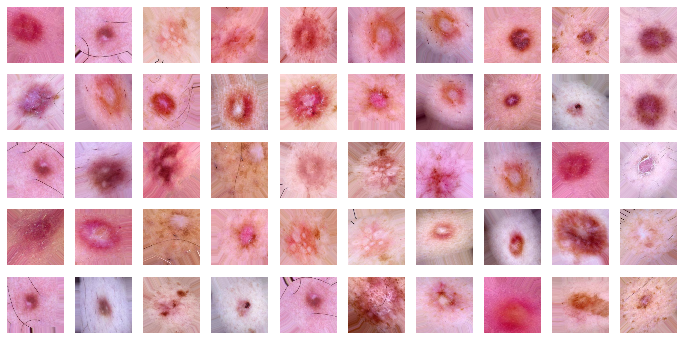

In [34]:

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [57]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

In [22]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [23]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 42069 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [24]:

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [25]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [26]:
type(mobile.layers)

list

In [27]:
# How many layers does MobileNet have?
len(mobile.layers)

92

In [28]:

# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [30]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [31]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [32]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [33]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [70]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

C:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
908/908 [==============================] - 1614s 2s/step - loss: 2.9654 - categorical_accuracy: 0.2615 - top_2_accuracy: 0.4584 - top_3_accuracy: 0.6196 - val_loss: 3.9614 - val_categorical_accuracy: 0.1962 - val_top_2_accuracy: 0.3081 - val_top_3_accuracy: 0.4264

Epoch 00001: val_top_3_accuracy improved from -inf to 0.42644, saving model to model.h5
Epoch 2/30
908/908 [==============================] - 1020s 1s/step - loss: 1.8261 - categorical_accuracy: 0.3932 - top_2_accuracy: 0.6095 - top_3_accuracy: 0.7617 - val_loss: 1.1499 - val_categorical_accuracy: 0.6706 - val_top_2_accuracy: 0.7878 - val_top_3_accuracy: 0.8902

Epoch 00002: val_top_3_accuracy improved from 0.42644 to 0.89019, saving model to model.h5
Epoch 3/30
908/908 [==============================] - 1021s 1s/step - loss: 1.6676 - categorical_accuracy: 0.4465 - top_2_accuracy: 0.6529 - top_3_accuracy: 0.7890 - val_loss: 1.2757 - val_categorical_accuracy: 0.5778 - val_top_2_accuracy: 0.8454 - val_top_3_accuracy

In [90]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [91]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 3.1022307872772217
val_cat_acc: 0.04797441512346268
val_top_2_acc: 0.10447761416435242
val_top_3_acc: 0.17377398908138275


In [92]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.35458943247795105
val_cat_acc: 0.868869960308075
val_top_2_acc: 0.9520255923271179
val_top_3_acc: 0.9861407279968262


In [93]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

NameError: name 'history' is not defined

In [75]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [76]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [94]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

C:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


938/938 [==============================] - 18s 19ms/step


In [95]:
predictions.shape

(938, 7)

In [96]:
predictions

array([[7.4578412e-02, 8.7261331e-01, 2.2862483e-02, ..., 8.3341124e-03,
        2.0674206e-02, 6.4474868e-04],
       [3.4201810e-01, 1.4059274e-02, 5.6143844e-01, ..., 6.0941298e-02,
        2.1436101e-02, 1.4329811e-05],
       [2.3581425e-02, 4.3224853e-02, 6.1924919e-02, ..., 5.4394084e-01,
        3.2705227e-01, 1.5923567e-04],
       ...,
       [1.2758912e-08, 2.1269278e-05, 3.5278483e-06, ..., 1.2268162e-04,
        8.2728988e-04, 9.9902439e-01],
       [7.0296030e-10, 1.3985084e-06, 1.5950560e-07, ..., 1.8455286e-05,
        5.5160184e-05, 9.9992478e-01],
       [8.2681323e-10, 8.6922375e-07, 4.6945425e-07, ..., 5.2812422e-05,
        3.8785979e-04, 9.9955791e-01]], dtype=float32)

In [80]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [81]:
test_labels.shape

(938,)

In [82]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [83]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  6   2  10   0   6   2   0]
 [  3  22   0   0   2   3   0]
 [  0   2  30   0  14  29   0]
 [  0   0   0   3   0   3   0]
 [  1   2   2   0  21  12   1]
 [  0   2   7   0  20 722   0]
 [  0   0   0   0   0   0  11]]


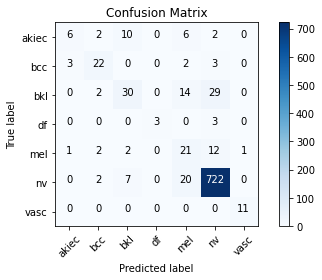

In [84]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [85]:
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [86]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.60      0.23      0.33        26
         bcc       0.73      0.73      0.73        30
         bkl       0.61      0.40      0.48        75
          df       1.00      0.50      0.67         6
         mel       0.33      0.54      0.41        39
          nv       0.94      0.96      0.95       751
        vasc       0.92      1.00      0.96        11

    accuracy                           0.87       938
   macro avg       0.73      0.62      0.65       938
weighted avg       0.87      0.87      0.86       938



In [90]:
predictions.argmax(axis=1)

array([1, 2, 4, 0, 4, 2, 1, 2, 0, 2, 2, 4, 4, 4, 0, 5, 2, 0, 2, 2, 5, 0,
       0, 4, 2, 2, 0, 5, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 4, 1, 1, 1, 5, 2, 5, 2, 5, 4, 4, 2, 4, 2,
       5, 4, 4, 2, 2, 2, 2, 5, 4, 5, 2, 2, 5, 5, 4, 4, 4, 2, 4, 5, 2, 5,
       5, 2, 4, 5, 5, 2, 2, 2, 1, 5, 5, 2, 2, 5, 2, 5, 2, 5, 2, 5, 2, 1,
       5, 5, 5, 5, 4, 4, 2, 2, 2, 5, 2, 2, 5, 2, 2, 5, 2, 5, 5, 5, 4, 3,
       3, 5, 5, 5, 3, 4, 4, 4, 4, 2, 5, 4, 4, 4, 5, 5, 2, 4, 4, 4, 6, 4,
       5, 4, 5, 4, 5, 5, 5, 1, 4, 4, 5, 5, 1, 5, 0, 4, 5, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [108]:
from tensorflow.keras.preprocessing import image
img_width, img_height = 150, 150
img = image.load_img('test\test.jpg', target_size = (img_width, img_height))

img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

predictions = model.predict(img)

OSError: [Errno 22] Invalid argument: 'test\test.jpg'

In [98]:
predictions.argmax(axis=1)

array([1], dtype=int64)

In [119]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load('test2.jpg')
predictions=model.predict(image)

In [120]:
predictions.argmax(axis=1)

array([6], dtype=int64)

In [117]:
predictions

array([[1.7491429e-06, 3.8291006e-03, 1.9204259e-04, 3.2774481e-04,
        2.7156197e-03, 3.2798976e-02, 9.6013474e-01]], dtype=float32)

In [7]:
import os
os.chdir('F:\main files\input')
import tensorflow as tf
from numpy.random import seed
seed(101)

tf.random.set_seed(101)

import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()


# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'



model.load_weights('model.h5')

from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load('test6.jpg')
predictions=model.predict(image)
print(predictions[0])
print(predictions[0])
l=[0,1,2,3,4,5,6]
h=predictions[0]
for i in range(7):
    for j in range(7):
        if h[i]>h[j]:
            h[i],h[j]=h[j],h[i]
            l[i],l[j]=l[j],l[i]
print(l)
print(h)
            
predictions.argmax(axis=1)[0]


[4.1083610e-03 6.6113728e-03 4.0427119e-01 3.1934655e-06 3.4089276e-01
 2.4410164e-01 1.1464283e-05]
[4.1083610e-03 6.6113728e-03 4.0427119e-01 3.1934655e-06 3.4089276e-01
 2.4410164e-01 1.1464283e-05]
[2, 4, 5, 1, 0, 6, 3]
[4.0427119e-01 3.4089276e-01 2.4410164e-01 6.6113728e-03 4.1083610e-03
 1.1464283e-05 3.1934655e-06]


0

In [39]:

# Print the label associated with each class
test_batches.class_indices


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

#### Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
#### basal cell carcinoma (bcc),
#### benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
#### dermatofibroma (df)
#### melanoma (mel)
#### melanocytic nevi (nv)
#### and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [2]:
worddict={'0':'Bowens disease (akiec)','1':'basal cell carcinoma (bcc)','2':'benign keratosis-like lesions','3':'dermatofibroma (df)','4':'melanoma (mel)', '5':'melanocytic nevi (nv)', '6':'vascular lesions'}
worddict['0']

'Bowens disease (akiec)'